**Modélisation des émissions de gaz à effet de serre**

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_row", 80)
pd.set_option("display.max_column", 80)

In [3]:
df = pd.read_csv('df_clean.csv', index_col=0)
print(df.shape)

# On ne garde qu'une seule target
target = 'TotalGHGEmissions'
df = df.drop('SiteEnergyUseWN(kBtu)', axis=1)

# On crée des variables contenant la proportion des sources d'énergie utilisées
df['TotalEnergyUse'] = df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']
df['SteamUse'] = df['SteamUse(kBtu)'] / df['TotalEnergyUse']
df['Electricity'] = df['Electricity(kBtu)'] / df['TotalEnergyUse']
df['NaturalGas'] = df['NaturalGas(kBtu)'] / df['TotalEnergyUse']

# On se débarasse des variables liées directement à nos target sauf 'GHGEmissionsIntensity'
# que l'on va utiliser pour le train_test_split
df = df.drop(columns=['SiteEUIWN(kBtu/sf)',
                      'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalEnergyUse'
                     ])
print(df.shape)
df.head()

(1578, 17)
(1578, 15)


,Neighborhood,YearBuilt,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,GHGEmissionsIntensity,SteamUse,Electricity,NaturalGas
0,DOWNTOWN,1927,12,Hotel,88434.0,None,0.0,None,0.0,60.0,249.98,2.83,0.277302,0.546060,0.176638
1,DOWNTOWN,1996,11,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,295.86,2.86,0.000000,0.386609,0.613391
2,DOWNTOWN,1969,41,Hotel,756493.0,None,0.0,None,0.0,43.0,2089.28,2.19,0.297113,0.682307,0.020579
3,DOWNTOWN,1926,10,Hotel,61320.0,None,0.0,None,0.0,56.0,286.43,4.67,0.325913,0.407519,0.266567
4,DOWNTOWN,1980,18,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,505.01,2.88,0.000000,0.378802,0.621198


# Fonctions

## Réduction de catégories

In [4]:
def merge_property_types(df):
    """
    Fonction servant à regrouper des types d'usage des bâtiments pour réduire le 
    nombre de catégorie
    """
    
    # Attribution du type d'usage au cas par cas
    
    police = [2150, 2938, 2442, 234, 2680]
    df.loc[police, 'LargestPropertyUseType'] = 'Police Station'

    fire_stations = [100, 819, 3020, 3361, 3362, 3363]
    df.loc[fire_stations, 'LargestPropertyUseType'] = 'Fire Station'

    theatre = [70, 1280]
    df.loc[theatre, 'LargestPropertyUseType'] = 'Movie Theater'

    arts = [75]
    df.loc[arts, 'LargestPropertyUseType'] = 'Performing Arts'

    health = [1972]
    df.loc[health, 'LargestPropertyUseType'] = 'Fitness Center/Health Club/Gym'

    meeting_hall = [73, 195]
    df.loc[meeting_hall, 'LargestPropertyUseType'] = 'Social/Meeting Hall'

    laboratory = [303, 1255]
    df.loc[laboratory, 'LargestPropertyUseType'] = 'Laboratory'

    K12_school = [632]
    df.loc[K12_school, 'LargestPropertyUseType'] = 'K-12 School'

    distribution_center = [2140]
    df.loc[distribution_center, 'LargestPropertyUseType'] = 'Distribution Center'

    hosptial = [3182]
    df.loc[hosptial, 'LargestPropertyUseType'] = 'Hospital'
    
    supermarket = [506]
    df.loc[supermarket, 'LargestPropertyUseType'] = 'Supermarket/Grocery Store'
    
    restaurant = [1317]
    df.loc[restaurant, 'LargestPropertyUseType'] = 'Restaurant'
    
    other = [3019]
    df.loc[other, 'LargestPropertyUseType'] = 'Other'
    
    automobile = [3233]
    df.loc[automobile, 'LargestPropertyUseType'] = 'Automobile Dealership'
    
    
    # Regroupement des types d'usage
    
    for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
        
        
        mask = ((df[col] == 'Small- and Mid-Sized Office')
                |(df[col] == 'Large Office')
                |(df[col] == 'Bank Branch')
                |(df[col] == 'Financial Office')
                |(df[col] == 'Police Station')
               )
        df.loc[mask, col] = 'Office'
        
        mask = ((df[col] == 'Movie Theater')
                | (df[col] == 'Museum')
                | (df[col] == 'Performing Arts'))
        df.loc[mask, col] = 'Entertainment/Public Assembly'

        mask = df[col] == 'Senior Care Community'
        df.loc[mask, col] = 'Residential Care Facility'

        mask = df[col] == 'Fitness Center/Health Club/Gym'
        df.loc[mask, col] = 'Recreation'

        mask = ((df[col] == 'Food Service')
               |(df[col] == 'Restaurant/Bar')
               |(df[col] == 'Fast Food Restaurant'))
        df.loc[mask, col] = 'Restaurant'

        mask = ((df[col] == 'Strip Mall')
               |(df[col] == 'Enclosed Mall'))
        df.loc[mask, col] = 'Mall'

        mask = ((df[col] == 'Distribution Center')
               |(df[col] == 'Non-Refrigerated Warehouse')
               |(df[col] == 'Wholesale Club/Supercenter'))
        df.loc[mask, col] = 'Warehouse'

        mask = ((df[col] == 'Specialty Hospital')
               |(df[col] == 'Urgent Care/Clinic/Outpatient')
               |(df[col] == 'Hospital (General Medical & Surgical)'))
        df.loc[mask, col] = 'Hospital'
        
        mask = ((df[col] == 'Convenience Store without Gas Station')
                |(df[col] == 'Food Sales'))
        df.loc[mask, col] = 'Supermarket/Grocery Store'

        mask = df[col] == 'Library'
        df.loc[mask, col] = 'Retail Store'
        
        mask = ((df[col] == 'Bar/Nightclub')
               |(df[col] == 'Vocational School')
               |(df[col] == 'Swimming Pool')
               |(df[col] == 'Technology/Science'))
        df.loc[mask, col] = 'Other'
        
    # Les types d'usages qui sont rares sont classés dans la catégorie 'Other',
    # sauf les 'Data Center' qui sont particuliers en raison de leur grande consommation
    # énergétique
    value_counts = df['LargestPropertyUseType'].value_counts()
    rare_classes = list(value_counts[value_counts < 5].index)
    for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
        for val in rare_classes:
            if val == 'Data Center':
                continue
            df.loc[df[col] == val, col] = 'Other'
    

## Encodage

### Encodage OneHot

On va définir une fonction pour appliquer un OneHotEncoding modifié dans lequel on va tenir compte de la répartition des différents usages d'un bâtiment. On n'aura donc pas des valeurs binaires dans les colonnes catégorielles mais des pourcentages correspondant à la surface occupée par rapport à la surface totale du bâtiment.

In [5]:
def ohe_encoding(df):
    
    df_ = df.copy()
        
    # On définit une colonne correspondant à la surface totale
    df_['TotalGFA'] = (df_['LargestPropertyUseTypeGFA'] 
                       + df_['SecondLargestPropertyUseTypeGFA']
                       + df_['ThirdLargestPropertyUseTypeGFA'])

    # Encodage OneHot modifié
    for ind in df_.index:
        # usage principal
        prop_type = df_.loc[ind, 'LargestPropertyUseType']
        df_.loc[ind, prop_type] = df_.loc[ind, 'LargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']

        # usage secondaire
        sec_prop_type = df_.loc[ind, 'SecondLargestPropertyUseType']
        try: # Si la colonne existe déjà
            if np.isnan(df_.loc[ind, sec_prop_type]):
                df_.loc[ind, sec_prop_type] = df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            else:
            # On utilise '+=' car il se peut que la case ait déjà été remplie si 'LargestPropertyUseTypeGFA'
            # et 'SecondLargestPropertyUseTypeGFA' sont du même type, et dans ce cas, on additionne les valeurs
                df_.loc[ind, sec_prop_type] += df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
        except KeyError:
            df_.loc[ind, sec_prop_type] = df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            
        # usage tertiaire
        third_prop_type = df_.loc[ind, 'ThirdLargestPropertyUseType']
        try:
            if np.isnan(df_.loc[ind, third_prop_type]):
                df_.loc[ind, third_prop_type] = df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            else:
                df_.loc[ind, third_prop_type] += df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
        except KeyError:
            df_.loc[ind, third_prop_type] = df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']

    df_ = df_.drop('None', axis=1) # la colonne 'None' ne contient que des 0
    # on remplace les NaN par 0 dans les colonnes créées
    df_.loc[:, 'TotalGFA':] = df_.loc[:, 'TotalGFA':].fillna(0)

    # On retire les colonnes dont on n'a plus besoin
    columns = df_.loc[:, 'LargestPropertyUseType':'ThirdLargestPropertyUseTypeGFA'].columns
    df_ = df_.drop(columns=columns)

    # Encodage des autres variables catégorielles (Neighborhood)
    df_ = pd.get_dummies(df_)
    # On renomme les colonnes issues de ces variables
    columns = []
    for col in df_.columns:
        try:
            columns.append(col.split('_')[1])
        except IndexError:
            columns.append(col)
            continue
    df_.columns = columns
    
    return df_

On vérifie que le programme fonctionne correctement en vérifiant que la somme des valeurs des colonnes issues de l'encodage est égale à 1 pour toutes les lignes

In [6]:
df_ = df.copy()
merge_property_types(df_)
df_ = ohe_encoding(df_)
s = df_.loc[:, 'Hotel':'Manufacturing/Industrial Plant'].sum(axis=1)
s.unique()

array([1., 1., 1.])

### Target Encoding

Pour `TargetEncoder`, on va choisir des paramètres telle que la corrélation entre la target et les variables catégorielles soit faible pour éviter le "target leakage"

In [7]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

te = TargetEncoder(min_samples_leaf=30, smoothing=5)

df_ = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_.drop(columns=target), df_[target], test_size=0.2, 
                                                    random_state=0)
#y_train, y_test = y_train.iloc[:, 0], y_test.iloc[:, 0]

X_train = te.fit_transform(X_train, y_train)
X_test = te.transform(X_test)

df_ = X_train.join(y_train)
for col in list(df.select_dtypes('object')):
    display(df_[[col, target]].corr())

,Neighborhood,TotalGHGEmissions
Neighborhood,1.000000,0.121199
TotalGHGEmissions,0.121199,1.000000


,LargestPropertyUseType,TotalGHGEmissions
LargestPropertyUseType,1.00000,0.16118
TotalGHGEmissions,0.16118,1.00000


,SecondLargestPropertyUseType,TotalGHGEmissions
SecondLargestPropertyUseType,1.000000,0.092353
TotalGHGEmissions,0.092353,1.000000


,ThirdLargestPropertyUseType,TotalGHGEmissions
ThirdLargestPropertyUseType,1.000000,0.132857
TotalGHGEmissions,0.132857,1.000000


In [8]:
def te_encoding(X_train, y_train, X_test):
    te = TargetEncoder(min_samples_leaf=30, smoothing=5)
    X_train = te.fit_transform(X_train, y_train)
    X_test = te.transform(X_test)
    return X_train, X_test

## Imputation des valeurs manquantes

In [9]:
def imputation(df, fill=False, label=None, value='median', columns=None):
    """
    Parameters
    ----------
    fill : boolean, default=False.
    
    label : None or object-type column name (str), default=None.
    
    value : 'median' or 'mean', default='median'.
    
    columns : None or list of strings, default=None
        List of columns to fill. If None, all columns containing NaN values will be filled.
    
    Returns
    ----------
    df_ : pandas DataFrame.
    """
    
    df_ = df.copy()
    
    if columns == None:
        mask = df_.columns.isin(df_.dropna(axis=1).columns)
        columns = df_.columns[~mask]
        
    if fill == False:
        df_ = df_.dropna()
        
    elif (fill == True and label != None):
        # On remplit les NaN en fonction de la valeur de label
        df_[columns] = df_[columns].fillna(df_.groupby(label)[columns].transform(value))
        # S'il reste de NaN, alors on les remplace tous par la même valeur
        if value == 'median':
            df_ = df_.fillna(df_.select_dtypes(np.number).median())
        elif value == 'mean':
            df_ = df_.fillna(df_.select_dtypes(np.number).mean())
            
    # Si label=None, on remplace directement tous les NaN par la même valeur
    elif (fill == True and label == None):
        if value == 'median':
            df_ = df_.fillna(df_.select_dtypes(np.number).median())
        elif value == 'mean':
            df_ = df_.fillna(df_.select_dtypes(np.number).mean())
            
    return df_

## Sélection de variables

In [10]:
from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif # use this for classification tasks
from sklearn.feature_selection import f_regression # use this for regression tasks
from sklearn.feature_selection import RFE

def feature_selection(X, y, model, n_features):    
    try:
        # Feature selection using Recursive Feature Elimimation (RFE)
        rfe = RFE(model, n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = list(X.columns[rfe.support_])
        
    except ValueError:
        # Select Features by Strength of Relationship to Target
        kbest = SelectKBest(score_func=f_regression, k=n_features)
        kbest.fit(X, y)
        selected_features = list(X.columns[kbest.get_support()])
    
    return selected_features

## Élimination des outliers

In [11]:
from sklearn.ensemble import IsolationForest

In [12]:
# On va modéliser nos données avec une IsolationForest pour repérer les outliers

df_ = df.select_dtypes(np.number)
df_ = df_.dropna(axis=1)

model_if = IsolationForest(random_state=0, contamination=0.02)
model_if.fit(df_)
outliers = model_if.predict(df_) == -1

print(df.shape)
df = df[~outliers]
print(df.shape)

(1578, 15)
(1546, 15)


## Évaluation

In [13]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [14]:
def evaluation(df, model, fill=False, label=None, value='median', columns=None, encoding='ohe', 
               log_scale=False, scaler=StandardScaler(), plot_learning_curve=False,
               figsize=(12, 8), hparams=None, scoring='r2', select_features=False, n_features=25,
               stratify=False, test_size=0.2, return_datasets=False, features_to_drop=[]):
    """
    Parameters
    ----------
    df : pandas DataFrame
        Data containing the features and the target.
    
    model : sklearn object type that implements the "fit" and "predict" methods
        
    fill : boolean, default=False
        Parameter of the `imputation` function.
    
    label : None or object-type column name (str), default=None
        Parameter of the `imputation` function.
    
    value : 'median' or 'mean', default='median'
        Parameter of the `imputation` function.
    
    columns : None or list of strings, default=None
        Parameter of the `imputation` function.
    
    encoding : str, 'le', 'ohe' or 'te', default='ohe'
    
    log_scale : boolean, default=False
        Whether to transform X into log(1+X) before scaling.
    
    scaler : Transformer
    
    plot_learning_curve : boolean, default=False
        
    figsize : (float, float), default=(12,8)
        Width, height in inches.
        
    hparams : dict or None, default=None
    
    scoring : 'r2', 'mae' or 'mse', default='r2'
    
    select_features : boolean, default=False
    
    n_features : int, default=25
    
    stratify : boolean, default=False
    
    test_size : float or int, default=0.2
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples.
        
    return_datasets : boolean, default=False
        If True returns X_train, X_test, y_train, y_test.
        
    features_to_drop : List of strings, empty by default
        List of features to drop before modelisation.
    
    Returns
    ----------
    
    """
    
    df_ = df.copy()
    df_ = df_.drop(columns=features_to_drop)
    
    # metrics for the scoring parameter
    metrics = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}
    
    
    # Pre-processing
    
    merge_property_types(df_)
    
    # Encodage et imputation
    if fill == True:
        df_ = imputation(df_, fill=fill, label=label, value=value, columns=columns)
    else:
        df_ = imputation(df_)
        
    property_types = df_['LargestPropertyUseType']
    
    if encoding == 'ohe': # OneHot Encoding
        df_ = ohe_encoding(df_)
    
    # Train/test split
    
    # On va essayer de répartir les bâtiments de manière homogène dans le train set
    # et le test set en utilisant la variable 'GHGEmissionsIntensity'. Pour cela, on
    # va transformer les valeurs de cette variable en intervalles
    if (fill == True or df_.shape[0] == df.shape[0]):
        df_['GHGEmissionsIntensity'] = pd.qcut(df_['GHGEmissionsIntensity'], 150, duplicates='drop')
    else:
        df_['GHGEmissionsIntensity'] = pd.qcut(df_['GHGEmissionsIntensity'], 120, duplicates='drop')
    # On transforme les intervalles en eniers à l'aide d'un LabelEncoder
    le = LabelEncoder()
    df_['GHGEmissionsIntensity'] = le.fit_transform(df_['GHGEmissionsIntensity'])

    X = df_.drop(target, axis=1)
    y = df_[target]
    # Si stratify vaut True on transforme les valeurs de y en intervalles pour 
    # pouvoir utiliser le StratifiedKFold
    if stratify == True:
        le = LabelEncoder()
        if df_.shape[0] == df.shape[0]:
            y = le.fit_transform(pd.qcut(y, 250, duplicates='drop'))
        else:
            y = le.fit_transform(pd.qcut(y, 150, duplicates='drop'))
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, 
                                                       stratify=X['GHGEmissionsIntensity'])
    X_train = X_train.drop('GHGEmissionsIntensity', axis=1)
    X_test = X_test.drop('GHGEmissionsIntensity', axis=1)
    
    # Target Encoding
    if encoding == 'te': # Target Encoding
        X_train, X_test = te_encoding(X_train, y_train, X_test)
        
    # Scaling
    if (log_scale == True and encoding == 'ohe'):
        columns = ['TotalGFA']
        X_train[columns] = np.log(1+X_train[columns])
        X_test[columns] = np.log(1+X_test[columns])
    elif (log_scale == True and encoding == 'te'):
        columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                   'ThirdLargestPropertyUseTypeGFA']
        X_train[columns] = np.log(1+X_train[columns])
        X_test[columns] = np.log(1+X_test[columns])
        
    X_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_, columns=X_train.columns, index=X_train.index)
    X_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_, columns=X_test.columns, index=X_test.index)
    
    # Sélection de variables
    if select_features == True:
        selected_features = feature_selection(X_train, y_train, model, n_features=n_features)
        X_train, X_test = X_train[selected_features], X_test[selected_features]
    print('X_train shape :', X_train.shape)
    print('X_test shape :', X_test.shape)
    
        

    # Recherche des meilleurs hyperparamètres
    
    if hparams != None:
        # Create 5 folds
        seed = 13
        if stratify == False:
            kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        grid = GridSearchCV(estimator=model, param_grid=hparams, cv=kfold, scoring=metrics[scoring])
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        print('Grid best score:', grid.best_score_)
    print(model)
    
    
    
    #Cross-validation
    
    # Create 5 folds
    seed = 7
    if stratify == False:
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    else:
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    # Train and evaluate multiple models using kfolds
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=metrics['r2'])
    #print('CV results: ', results)
    print("CV Mean:", results.mean().round(3))
    print("CV Std:", results.std().round(3))
    
    
    
    # Modelisation of the test set

    # Fit model
    model.fit(X_train, y_train)
    # Evaluate model
    predictions = model.predict(X_test)
    print('test score :', r2_score(y_test, predictions).round(3))
    #print('MAE :', mean_absolute_error(y_test, predictions))
    #print('MSE :', mean_squared_error(y_test, predictions))
    
    
    
    # Learning curve
    if plot_learning_curve == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                   train_sizes=np.linspace(0.1, 1, 10), cv=5)
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label='train')
        plt.plot(N, val_score.mean(axis=1), label='validation')
        plt.title(type(model).__name__)
        plt.xlabel('train_sizes')
        plt.legend();
    

    if return_datasets == True:
        return X_train, X_test, y_train, y_test
            

# Modélisation

## KNeighborsRegressor

In [15]:
from sklearn.neighbors import KNeighborsRegressor

In [16]:
hparams_knr = [{'n_neighbors': np.arange(2, 15, 1),
            'weights': ['uniform','distance']}]

model_knr = KNeighborsRegressor()

evaluation(df, model_knr, fill=True, label='Neighborhood', value='median', hparams=hparams_knr, encoding='te',
           select_features=True, n_features=30, log_scale=True, scoring='mae',
           plot_learning_curve=False, test_size=.2)

X_train shape : (1236, 13)
X_test shape : (310, 13)
Grid best score: -70.83501825205485
KNeighborsRegressor(n_neighbors=7, weights='distance')
CV Mean: 0.402
CV Std: 0.154
test score : 0.32


## SGDR

In [17]:
from sklearn.linear_model import SGDRegressor

X_train shape : (1236, 20)
X_test shape : (310, 20)
Grid best score: 0.475811679701328
SGDRegressor(alpha=0.1, random_state=0)
CV Mean: 0.419
CV Std: 0.055
test score : 0.452


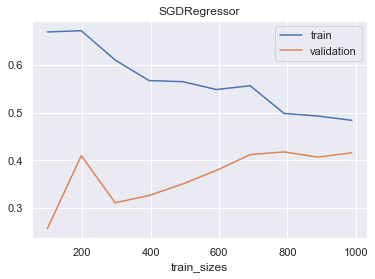

In [18]:
hparams_sgdr = {'penalty': ['l2', 'l1', 'elasticnet'], 
                'alpha': np.logspace(-2, 2, 5),
                #'tol': np.logspace(-3, -1, 3)
            }

model_sgdr = SGDRegressor(random_state=0)

evaluation(df, model_sgdr, fill=True, label='Neighborhood', value='median', 
           hparams=hparams_sgdr, encoding='ohe',# scoring='mae',
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2)

## SVR

In [19]:
from sklearn.svm import SVR

X_train shape : (1236, 20)
X_test shape : (310, 20)
SVR(C=1000.0)
CV Mean: 0.543
CV Std: 0.102
test score : 0.444


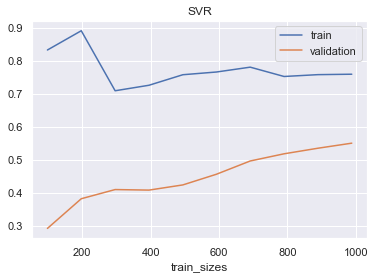

In [20]:
hparams_svr = {'kernel': ['linear', 'rbf'],
            #'gamma': ['auto', 'scale'],
            #'degree': [2,3,4,5],
            'C': [1e3, 1e4, 1e5],
            #'epsilon': np.logspace(-5, -1, 5)
          }

model_svr = SVR(C=1e3)

evaluation(df, model_svr, fill=True, label='Neighborhood', value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=20,
           plot_learning_curve=True, test_size=.2)

## KernelRidge

In [21]:
from sklearn.kernel_ridge import KernelRidge

X_train shape : (1236, 25)
X_test shape : (310, 25)
KernelRidge(degree=2, kernel='poly')
CV Mean: 0.566
CV Std: 0.078
test score : 0.578


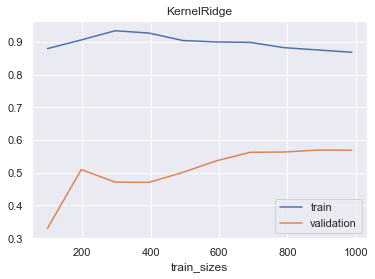

In [22]:
hparams_krr = {'alpha': np.logspace(-2, 2, 5),
               #'kernel': ['poly', 'chi2', 'additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'cosine'], 
               'degree': np.arange(2, 6, 1),
               #'gamma': np.logspace(-4, 0, 5)
          }

model_krr = KernelRidge(alpha=1, degree=2, kernel='poly')

evaluation(df, model_krr, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=25, log_scale=False,# scoring='mse',
           plot_learning_curve=True, test_size=.2)

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

X_train shape : (1236, 47)
X_test shape : (310, 47)
RandomForestRegressor(random_state=0)
CV Mean: 0.642
CV Std: 0.045
test score : 0.641


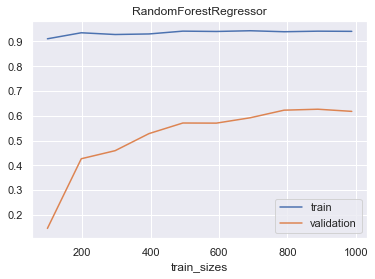

In [24]:
model_rfr = RandomForestRegressor(n_estimators=100, random_state=0)

evaluation(df, model_rfr, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=False, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2)

## Voting

In [25]:
from sklearn.ensemble import VotingRegressor

X_train shape : (1236, 25)
X_test shape : (310, 25)
VotingRegressor(estimators=[('KNN',
                             KNeighborsRegressor(n_neighbors=10,
                                                 weights='distance')),
                            ('Kernel Ridge',
                             KernelRidge(degree=2, kernel='poly')),
                            ('Random Forest',
                             RandomForestRegressor(random_state=0))])
CV Mean: 0.634
CV Std: 0.068
test score : 0.629


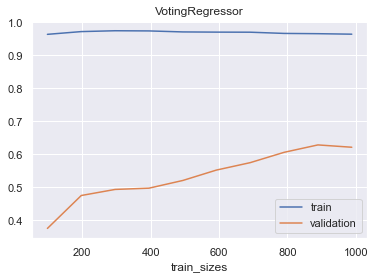

In [26]:
model_knr = KNeighborsRegressor(n_neighbors=10, weights='distance')
model_sgdr = SGDRegressor(alpha=1.0, penalty='elasticnet', random_state=0)
model_svr = SVR(C=1e3, kernel='linear')
model_krr = KernelRidge(alpha=1, degree=2, kernel='poly')
model_rfr = RandomForestRegressor(random_state=0)

voting = VotingRegressor([('KNN', model_knr),
                          #('SGDR', model_sgdr),
                          #('SVR', model_svr),
                          ('Kernel Ridge', model_krr),
                          ('Random Forest', model_rfr)
                        ])

evaluation(df, voting, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=25, 
           plot_learning_curve=True, test_size=.2)

## Bagging

In [27]:
from sklearn.ensemble import BaggingRegressor

X_train shape : (1236, 20)
X_test shape : (310, 20)
BaggingRegressor(n_estimators=100, random_state=0)
CV Mean: 0.622
CV Std: 0.054
test score : 0.622


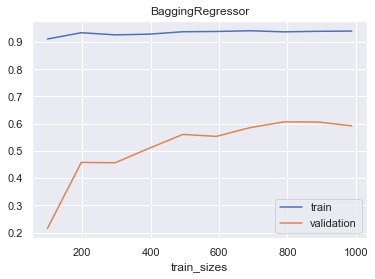

In [28]:
bagging = BaggingRegressor(n_estimators=100, random_state=0)

evaluation(df, bagging, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=20, 
           plot_learning_curve=True, test_size=.2)

X_train shape : (1236, 25)
X_test shape : (310, 25)
BaggingRegressor(base_estimator=KernelRidge(degree=2, kernel='poly'),
                 n_estimators=50, random_state=0)
CV Mean: 0.605
CV Std: 0.047
test score : 0.597


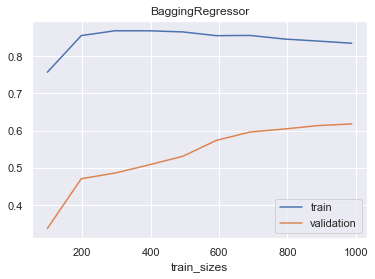

In [29]:
estimator = KernelRidge(degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=50, random_state=0)

evaluation(df, bagging, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=25, 
           plot_learning_curve=True, test_size=.2)

## Boosting

### AdaBoostRegressor

In [30]:
from sklearn.ensemble import AdaBoostRegressor

X_train shape : (821, 42)
X_test shape : (206, 42)
Grid best score: 0.4856259940909903
AdaBoostRegressor(learning_rate=0.1, random_state=0)
CV Mean: 0.512
CV Std: 0.086
test score : 0.533


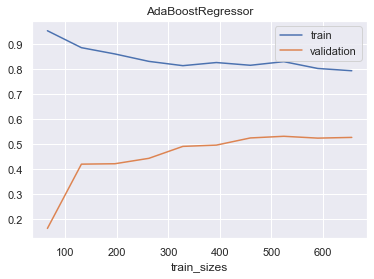

In [31]:
hparams_abr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-2, 2, 5),
               'loss': ['linear', 'square']
              }

adaboost = AdaBoostRegressor(n_estimators=50, random_state=0)

evaluation(df, adaboost, fill=False, label=None, value='median', hparams=hparams_abr, encoding='ohe',
           select_features=False, n_features=25, 
           plot_learning_curve=True, test_size=.2)

X_train shape : (1236, 20)
X_test shape : (310, 20)
AdaBoostRegressor(base_estimator=KernelRidge(degree=2, kernel='poly'),
                  n_estimators=5, random_state=0)
CV Mean: 0.412
CV Std: 0.167
test score : 0.525


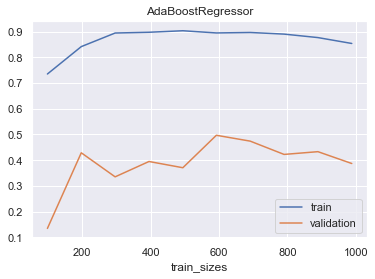

In [32]:
estimator = KernelRidge(degree=2, kernel='poly')
adaboost = AdaBoostRegressor(base_estimator=estimator, n_estimators=5, random_state=0)

evaluation(df, adaboost, fill=True, label=None, value='median', hparams=None, encoding='ohe', 
           select_features=True, n_features=20, log_scale=False, scaler=StandardScaler(),
           plot_learning_curve=True, test_size=.2)

### Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

X_train shape : (1236, 20)
X_test shape : (310, 20)
Grid best score: 0.5579205895091505
GradientBoostingRegressor(loss='absolute_error', random_state=0)
CV Mean: 0.51
CV Std: 0.114
test score : 0.506


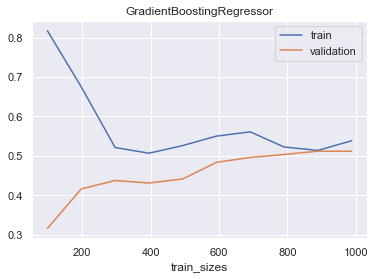

In [34]:
hparams_gbr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-3, 0, 4),
               'loss': ['squared_error', 'absolute_error'],
               #'max_depth': [2,3,4],
               #'min_samples_leaf': [3],
               #'tol': np.logspace(-6, -4, 3)
              }

model_gbr = GradientBoostingRegressor(n_estimators=50, random_state=0)

evaluation(df, model_gbr, fill=True, label=None, value='median', hparams=hparams_gbr, encoding='ohe', 
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2)

# Fine tuning du meilleur modèle

X_train shape : (821, 13)
X_test shape : (206, 13)
BaggingRegressor(base_estimator=KernelRidge(degree=2, kernel='poly'),
                 max_features=0.75, n_estimators=30, random_state=0)
CV Mean: 0.538
CV Std: 0.246
test score : 0.745


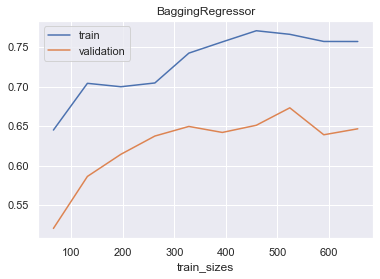

In [35]:
estimator = KernelRidge(alpha=1, degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, max_features=0.75, n_estimators=30, random_state=0)

hparams_bag = {#'base_estimator__alpha': np.logspace(-2, 0, 3),
               #'base_estimator__kernel': ['poly', 'rbf', 'laplacian', 'sigmoid', 'chi2', 'cosine']
               #'max_features': [.85, .90, .95],
               #'max_samples': [.5, .75, 1.],
               'n_estimators': [25, 30, 35]
              }

evaluation(df, bagging, fill=False, label=None, value='median', hparams=None, encoding='te',
           select_features=False, n_features=25, 
           plot_learning_curve=True, test_size=.2)

X_train shape : (821, 13)
X_test shape : (206, 13)
RandomForestRegressor(max_features=0.75, random_state=0)
CV Mean: 0.691
CV Std: 0.069
test score : 0.645


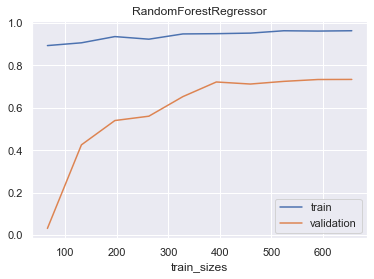

In [36]:
model_rfr = RandomForestRegressor(n_estimators=100, max_features=.75, random_state=0)

hparams_rfr = {#'min_samples_split': np.arange(2, 5, 1),
               #'min_samples_leaf': np.arange(1, 4, 1),
               #'min_weight_fraction_leaf': [0., 0.15, 0.3],
               'max_features': [.60, .75, .90],
              }

evaluation(df, model_rfr, fill=False, label=None, value='median', hparams=None, encoding='te',
           select_features=False, n_features=40, log_scale=False, scaler=StandardScaler(),
           plot_learning_curve=True, test_size=.2)

On va prendre comme modèle final le BagginRegressor car c'est celui qui présente le moins d'overfitting

# Feature importance

X_train shape : (821, 13)
X_test shape : (206, 13)
BaggingRegressor(base_estimator=KernelRidge(degree=2, kernel='poly'),
                 max_features=0.75, n_estimators=30, random_state=0)
CV Mean: 0.538
CV Std: 0.246
test score : 0.745


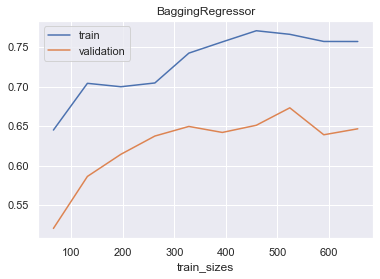

In [37]:
estimator = KernelRidge(alpha=1, degree=2, kernel='poly')
final_model = BaggingRegressor(base_estimator=estimator, max_features=0.75, n_estimators=30, random_state=0)

X_train, X_test, y_train, y_test = evaluation(df, final_model, fill=False, label=None, value='median',
                                        encoding='te', select_features=False, n_features=25, 
                                        plot_learning_curve=True, test_size=.2, return_datasets=True)

In [78]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(821, 13) (821,)
(206, 13) (206,)


In [79]:
import shap
#shap.initjs()

## Compilation des shap values

La cellule qui suit va calculer les SHAP values. Le temps de calcul peut être relativement long donc si le code précédent n'a pas été modifié, vous pouvez importer les SHAP values sauvegardées dans ce répertoire comme indiqué dans la cellule d'après.

In [80]:
# background data
X_back = shap.utils.sample(X_train, 200)

final_model.fit(X_train, y_train)

explainer = shap.Explainer(final_model.predict, X_back)
shap_values = explainer(X_test)
shap_vals = shap_values.values
base_value = shap_values.base_values[0]

Permutation explainer: 207it [16:55,  4.98s/it]                         


```Python
# Pour sauvegarder les shap values
import pickle
with open('shap_values_target2_bagging', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump(shap_values)

# Pour les importer
with open('shap_values_target2_bagging', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    shap_values = my_depickler.load()
```

On va évaluer la qualité des shap values en calculant le R$^2$ entre les valeurs prédites par le modèles et celles prédites par shap

In [41]:
# Valeurs prédites par le modèle
predictions = final_model.predict(X_test)

# Valeurs prédites à partir des shap values
shap_predictions = base_value + shap_vals.sum(axis=1)

# Somme des carrés résiduelle
SSR = ((predictions - shap_predictions)**2).sum()

# Somme des carrés totale
SST = ((predictions - predictions.mean())**2).sum()

R2 = 1 - SSR/SST
R2

1.0

Visualisation graphique

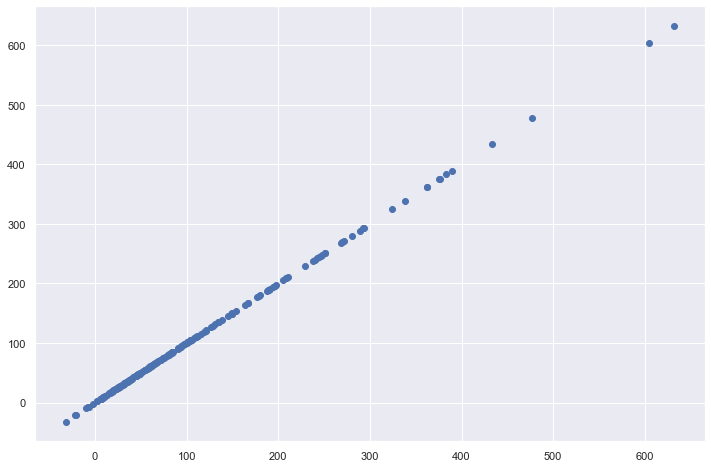

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(predictions, shap_predictions)

Les valeurs prédites par le modèle et shap sont les mêmes

## Influence globale des variables

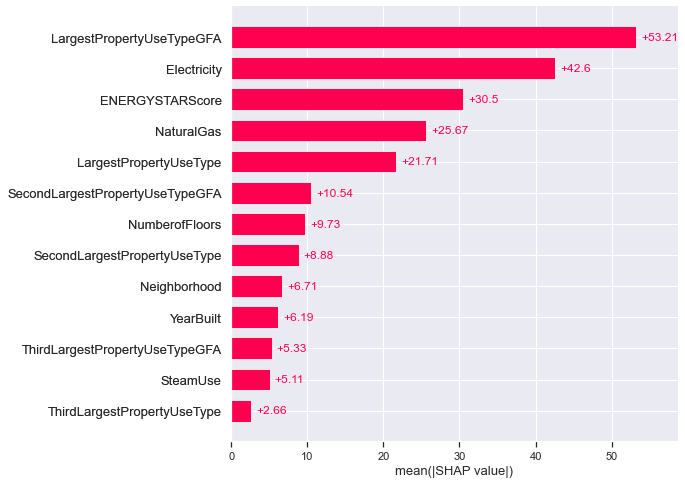

In [43]:
# Moyenne de la valeur absolue des shap values
shap.plots.bar(shap_values, max_display=13)

On remarque ici aussi que l'ENERGYSTARScore figure parmis les variables les plus importantes.

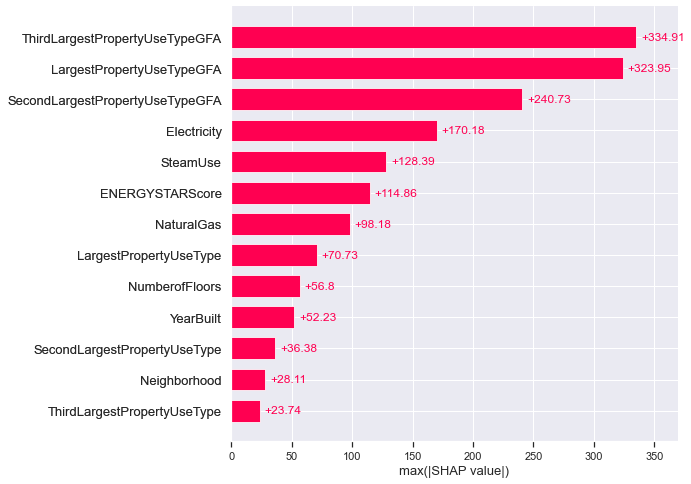

In [44]:
# Valeur maximale de la shap value en valeur absolue
shap.plots.bar(shap_values.abs.max(0), max_display=13)

## Influence locale

Prenons un bâtiment au hasard et regardons ses shap values

In [45]:
shap_ind = np.random.randint(0, shap_vals.shape[0])
ind = X_test.iloc[[shap_ind]].index
print(shap_ind)
print(ind.values)
df.loc[int(ind.values)]

18
[895]


Neighborhood                          DOWNTOWN
YearBuilt                                 1957
NumberofFloors                               2
LargestPropertyUseType             K-12 School
LargestPropertyUseTypeGFA              21600.0
SecondLargestPropertyUseType              None
SecondLargestPropertyUseTypeGFA            0.0
ThirdLargestPropertyUseType               None
ThirdLargestPropertyUseTypeGFA             0.0
ENERGYSTARScore                           72.0
TotalGHGEmissions                        38.87
GHGEmissionsIntensity                      1.8
SteamUse                                   0.0
Electricity                           0.483318
NaturalGas                            0.516682
Name: 895, dtype: object

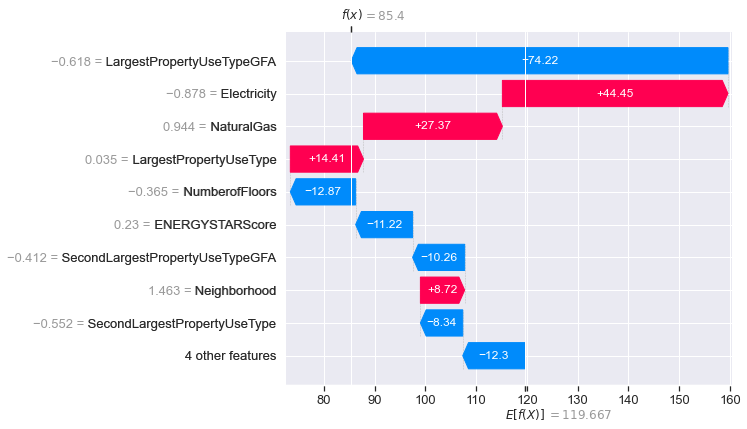

In [46]:
shap.plots.waterfall(shap_values[shap_ind])

On peut voir que pour ce bâtiment les variables les plus importantes sont les proportions d'électricité et de gaz utilisées, l'ENERGYSTARScore, le type d'usage principal et la surface associée.

Visualisons maintenant l'ensemble des shap values à l'aide d'un beeswarm plot

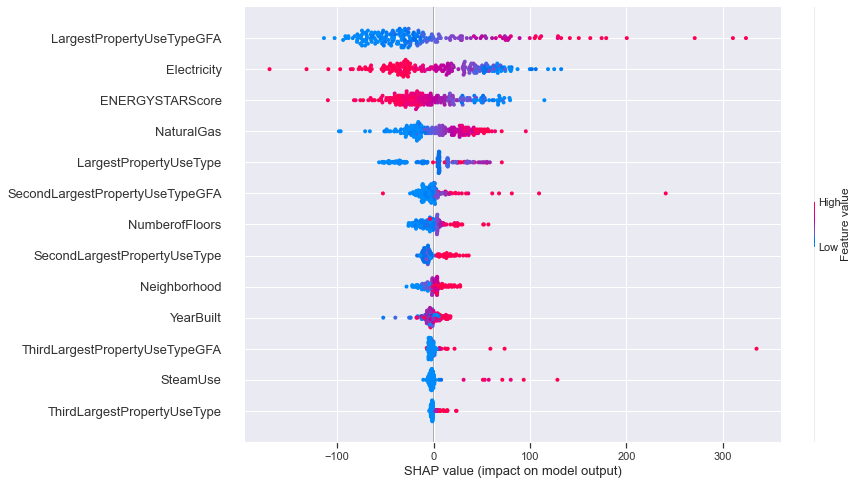

In [47]:
shap.plots.beeswarm(shap_values, plot_size=(12,8), log_scale=False, max_display=13)

On peut en conclure que :
- Plus le bâtiment est grand (surface et nb d'étages), plus il émet de GES
- Plus l'ENERGYSTARScore est élevé, moins il émet de GES
- Plus la proportion d'électricité utilisée est grande, moins il émet de GES
- Plus la proportion de gaz utilisée est grande, plus il émet de GES,
- Plus la proportion de vapeur utilisée est grande, plus il émet de GES

# Sans l'ENERGYSTARScore

## Modélisation

### KNeighborsRegressor

X_train shape : (1236, 12)
X_test shape : (310, 12)
Grid best score: 0.48302421920341965
KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')
CV Mean: 0.449
CV Std: 0.112
test score : 0.391


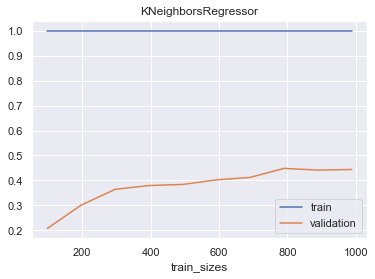

In [48]:
hparams_knr = {'n_neighbors': np.arange(2, 10, 1), 
               'weights': ['uniform','distance'],
               #'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
               #'p': [1, 2]
              }

model_knr = KNeighborsRegressor(metric='manhattan')

evaluation(df, model_knr, hparams=hparams_knr, encoding='te', scaler=StandardScaler(),
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### SGDR

X_train shape : (1236, 25)
X_test shape : (310, 25)
Grid best score: 0.44593831129368605
SGDRegressor(alpha=0.01, penalty='elasticnet', random_state=0)
CV Mean: 0.403
CV Std: 0.067
test score : 0.438


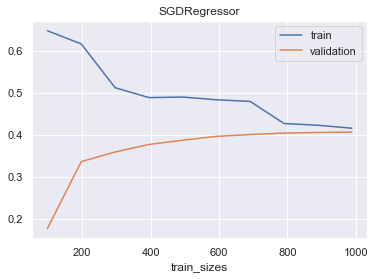

In [49]:
hparams_sgdr = {'penalty': ['l2', 'l1', 'elasticnet'], 
                'alpha': np.logspace(-2, 1, 4),
                #'tol': np.logspace(-3, -1, 3)
            }

model_sgdr = SGDRegressor(random_state=0)

evaluation(df, model_sgdr, hparams=hparams_sgdr, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### SVR

X_train shape : (1236, 12)
X_test shape : (310, 12)
SVR(C=10000.0)
CV Mean: 0.577
CV Std: 0.031
test score : 0.478


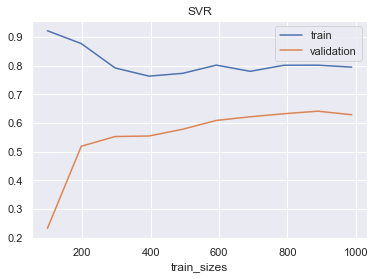

In [50]:
hparams_svr = {'kernel': ['linear', 'rbf', 'poly', 'laplacian', 'cosine', 'chi2'],
               #'gamma': ['auto', 'scale'],
               #'degree': [2,3,4,5],
               #'C': [1e3, 1e4, 1e5],
               #'epsilon': np.logspace(-5, -1, 5)
              }

model_svr = SVR(C=1e4)

evaluation(df, model_svr, hparams=None, encoding='te', scaler=MinMaxScaler(),
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### KernelRidge

X_train shape : (1236, 35)
X_test shape : (310, 35)
KernelRidge(degree=2, kernel='poly')
CV Mean: 0.599
CV Std: 0.102
test score : 0.583


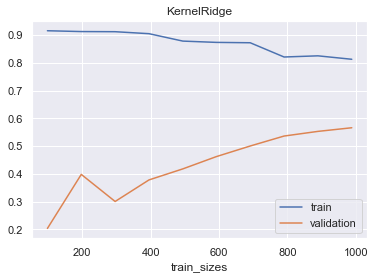

In [51]:
hparams_krr = {#'alpha': np.logspace(-2, 2, 5),
               'kernel': ['poly', 'rbf', 'laplacian', 'sigmoid', 'cosine', 'chi2'], 
               #'degree': np.arange(2, 6, 1),
               #'gamma': np.logspace(-4, 0, 5)
              }

model_krr = KernelRidge(kernel='poly', degree=2)

evaluation(df, model_krr, hparams=None, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=35, log_scale=True, scoring='r2',
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Random Forest

X_train shape : (1236, 25)
X_test shape : (310, 25)
RandomForestRegressor(random_state=0)
CV Mean: 0.615
CV Std: 0.036
test score : 0.604


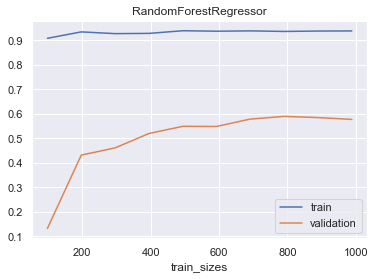

In [52]:
hparams_rfr = {'min_samples_split': np.arange(1,5,1),
               'min_samples_leaf': np.arange(1,5,1)
              }

model_rfr = RandomForestRegressor(n_estimators=100, random_state=0)

evaluation(df, model_rfr, hparams=None, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Voting

In [53]:
model_knr = KNeighborsRegressor(n_neighbors=5, weights='distance')
model_sgdr = SGDRegressor(alpha=.01, penalty='elasticnet', random_state=0)
model_svr = SVR(C=1e3, kernel='linear')
model_krr = KernelRidge(alpha=1, degree=2, kernel='poly')
model_rfr = RandomForestRegressor(random_state=0)

voting = VotingRegressor([#('KNN', model_knr),
                          ('SGDR', model_sgdr),
                          ('SVR', model_svr),
                          #('Kernel Ridge', model_krr),
                          ('Random Forest', model_rfr)
                         ])

evaluation(df, voting, hparams=None, encoding='ohe',
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=False, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1236, 46)
X_test shape : (310, 46)
VotingRegressor(estimators=[('SGDR',
                             SGDRegressor(alpha=0.01, penalty='elasticnet',
                                          random_state=0)),
                            ('SVR', SVR(C=1000.0, kernel='linear')),
                            ('Random Forest',
                             RandomForestRegressor(random_state=0))])
CV Mean: 0.537
CV Std: 0.063
test score : 0.543


### Bagging

X_train shape : (1236, 12)
X_test shape : (310, 12)
BaggingRegressor(n_estimators=100, random_state=0)
CV Mean: 0.617
CV Std: 0.076
test score : 0.555


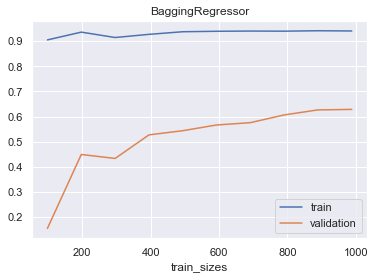

In [54]:
hparams_bag = {'n_estimators': [10, 30, 50],
               'max_samples': [.5, .75, 1.],
               'max_features': [.5, .75, 1.]
              }

bagging = BaggingRegressor(n_estimators=100, random_state=0)

evaluation(df, bagging, hparams=None, encoding='te', scaler=StandardScaler(),
           select_features=True, n_features=25, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1236, 46)
X_test shape : (310, 46)
BaggingRegressor(base_estimator=KernelRidge(degree=2, kernel='poly'),
                 random_state=0)
CV Mean: 0.561
CV Std: 0.125
test score : 0.585


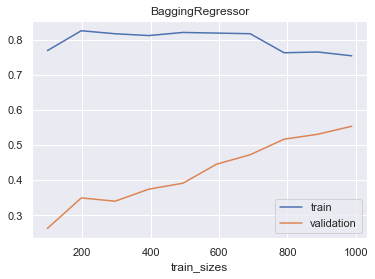

In [55]:
estimator = KernelRidge(degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=10, random_state=0)

hparams_bag = {#'base_estimator__alpha': np.logspace(-3, 0, 4),
               #'base_estimator__degree': [2, 3, 4],
               'max_features': [.25, .5, .75, 1.],
               'max_samples': [.25, .5, .75, 1.]
              }

evaluation(df, bagging, hparams=None, encoding='ohe', #scaler=MinMaxScaler(),
           select_features=False, n_features=35, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Boosting

#### AdaBoostRegressor

In [56]:
hparams_abr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-2, 2, 5),
               'loss': ['linear', 'square']
              }

adaboost = AdaBoostRegressor(n_estimators=10, random_state=0)

evaluation(df, adaboost, hparams=hparams_abr, encoding='te', scaler=StandardScaler(),
           select_features=False, n_features=20, log_scale=True,
           plot_learning_curve=False, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1236, 12)
X_test shape : (310, 12)
Grid best score: 0.4656026867287874
AdaBoostRegressor(learning_rate=0.01, loss='square', n_estimators=10,
                  random_state=0)
CV Mean: 0.372
CV Std: 0.082
test score : 0.368


X_train shape : (1236, 30)
X_test shape : (310, 30)
AdaBoostRegressor(base_estimator=KernelRidge(alpha=0.001, degree=2,
                                             kernel='laplacian'),
                  learning_rate=0.1, n_estimators=10, random_state=0)
CV Mean: 0.608
CV Std: 0.087
test score : 0.604


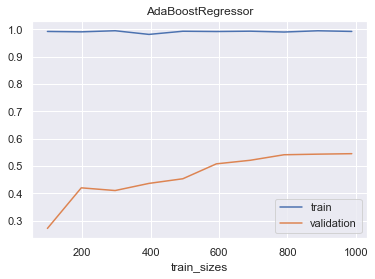

In [57]:
estimator = KernelRidge(alpha=.001, degree=2, kernel='laplacian')
adaboost = AdaBoostRegressor(base_estimator=estimator, n_estimators=10, learning_rate=.1, random_state=0)

hparams_abr = {'base_estimator__alpha': np.logspace(-3, 0, 4),
               #'base_estimator__kernel': ['rbf', 'laplacian', 'chi2', 'cosine', 'linear']
               #'base_estimator__degree': [2, 3, 4],
               'learning_rate': np.logspace(-2, 1, 4)
              }

evaluation(df, adaboost, hparams=None, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=30, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

#### Gradient Boosting

X_train shape : (1236, 20)
X_test shape : (310, 20)
GradientBoostingRegressor(loss='absolute_error', random_state=0)
CV Mean: 0.476
CV Std: 0.109
test score : 0.463


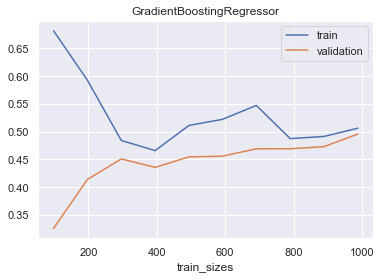

In [58]:
hparams_gbr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-3, 0, 4),
               'loss': ['squared_error', 'absolute_error'],
               #'max_depth': [2,3,4],
               #'min_samples_leaf': [3],
               #'tol': np.logspace(-6, -4, 3)
          }

model_gbr = GradientBoostingRegressor(loss='absolute_error', random_state=0)

evaluation(df, model_gbr, hparams=None, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=20, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

## Fine tuning du meilleur modèle

X_train shape : (1236, 12)
X_test shape : (310, 12)
SVR(C=10000.0)
CV Mean: 0.577
CV Std: 0.031
test score : 0.478


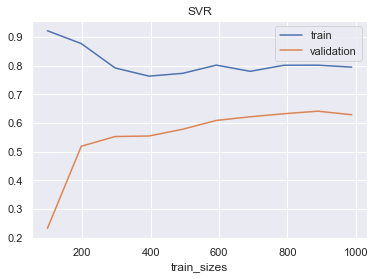

In [59]:
hparams_svr = {'C': [5000, 10000, 20000],
               #'gamma': np.logspace(-2, 1, 4),
               #'kernel': ['linear', 'rbf', 'poly', 'laplacian', 'cosine', 'chi2'],
               #'degree': [2,3,4,5],
               #'epsilon': np.logspace(-5, -1, 5),
               #'tol': np.logspace(-8, -6, 3)
              }

model_svr = SVR(C=1e4)

evaluation(df, model_svr, hparams=None, encoding='te', scaler=MinMaxScaler(),
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1236, 25)
X_test shape : (310, 25)
RandomForestRegressor(max_features=0.5, min_samples_split=3, random_state=0)
CV Mean: 0.611
CV Std: 0.071
test score : 0.584


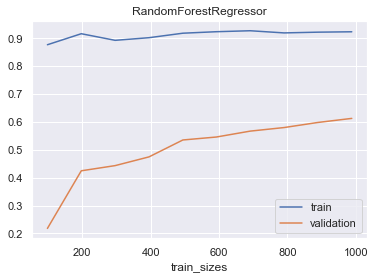

In [60]:
hparams_rfr = {'n_estimators' : [150, 200],
               #'criterion': ["squared_error", "absolute_error", "poisson"]
               #'min_samples_split': np.arange(1,5,1),
               #'min_samples_leaf': np.arange(1,5,1),
               #'max_features': [.25, .5, .75, 1.]
              }

model_rfr = RandomForestRegressor(max_features=0.5, min_samples_split=3, n_estimators=100,
                      random_state=0)

evaluation(df, model_rfr, hparams=None, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1236, 25)
X_test shape : (310, 25)
BaggingRegressor(base_estimator=KernelRidge(alpha=0.1, degree=2, kernel='poly'),
                 max_features=0.75, n_estimators=50, random_state=0)
CV Mean: 0.584
CV Std: 0.079
test score : 0.587


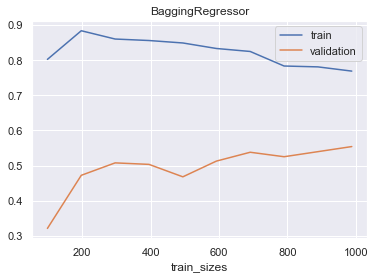

In [61]:
estimator = KernelRidge(degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=50, random_state=0)
bagging = BaggingRegressor(base_estimator=KernelRidge(alpha=0.1, degree=2, kernel='poly'),
                 max_features=0.75, n_estimators=50, random_state=0)

hparams_bag = {'base_estimator__alpha': np.logspace(-2, 0, 3),
               #'base_estimator__degree': [2, 3, 4],
               'n_estimators': [10, 30, 50],
               'max_features': [.5, .75, 1.],
               'max_samples': [.5, .75, 1.]
              }

evaluation(df, bagging, hparams=None, encoding='ohe', #scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

On voit que, comme pour la consommation d'énergie, le modèle a plus de mal à reproduire les données sans l'ENERGYSTARScore. On va utiliser ici le SVR car il présente moins d'overfitting que la RandomForest et un meilleur score sur la cross-validation que le BaggingRegressor.

## Feature importance

X_train shape : (1236, 12)
X_test shape : (310, 12)
SVR(C=10000.0)
CV Mean: 0.577
CV Std: 0.031
test score : 0.478


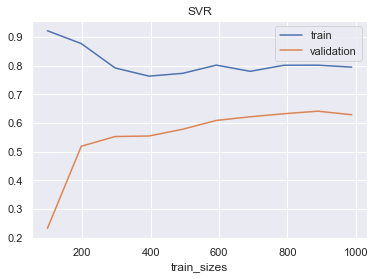

In [62]:
final_model_2 = SVR(C=1e4)

X_train, X_test, y_train, y_test = evaluation(df, final_model_2, hparams=None, encoding='te', 
                                              scaler=MinMaxScaler(), select_features=False, n_features=25, 
                                              log_scale=False, plot_learning_curve=True, test_size=.2, 
                                              features_to_drop=['ENERGYSTARScore'], return_datasets=True)

In [63]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1236, 12) (1236,)
(310, 12) (310,)


In [64]:
import shap

### Compilation des shap values

In [65]:
# background data
X_back = shap.utils.sample(X_train, 200)

final_model_2.fit(X_train, y_train)

explainer = shap.Explainer(final_model_2.predict, X_back)
shap_values = explainer(X_test)
shap_vals = shap_values.values
base_value = shap_values.base_values[0]

Permutation explainer: 311it [20:36,  4.01s/it]                         


```Python
# Pour sauvegarder les shap values
import pickle
with open('shap_values_target2_2_svr', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump(shap_values)

# Pour les importer
with open('shap_values_target2_2_svr', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    shap_values = my_depickler.load()
```

On va évaluer la qualité des shap values en calculant le R$^2$ entre les valeurs prédites par le modèles et celles prédites par shap

In [66]:
# Valeurs prédites par le modèle
predictions = final_model_2.predict(X_test)

# Valeurs prédites à partir des shap values
shap_predictions = base_value + shap_vals.sum(axis=1)

# Somme des carrés résiduelle
SSR = ((predictions - shap_predictions)**2).sum()

# Somme des carrés totale
SST = ((predictions - predictions.mean())**2).sum()

R2 = 1 - SSR/SST
R2

1.0

Visualisation graphique

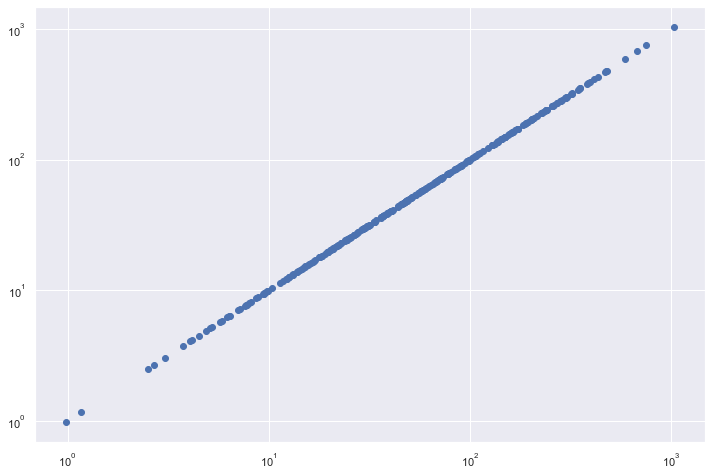

In [67]:
plt.figure(figsize=(12,8))
plt.scatter(predictions, shap_predictions)
plt.xscale('log')
plt.yscale('log')
xticks = (list(np.linspace(1, 9, 9)*1e5) + list(np.linspace(1, 9, 9)*1e6) + list(np.linspace(1, 10, 10)*1e7))
#plt.xticks(xticks);

## Influence globale des variables

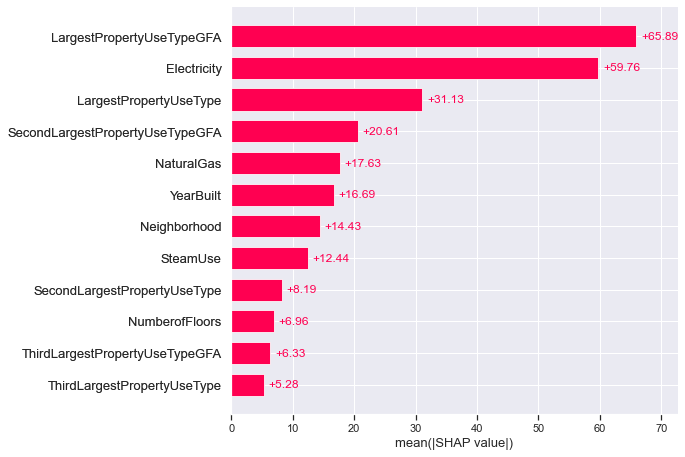

In [68]:
# Moyenne de la valeur absolue des shap values
shap.plots.bar(shap_values, max_display=13)

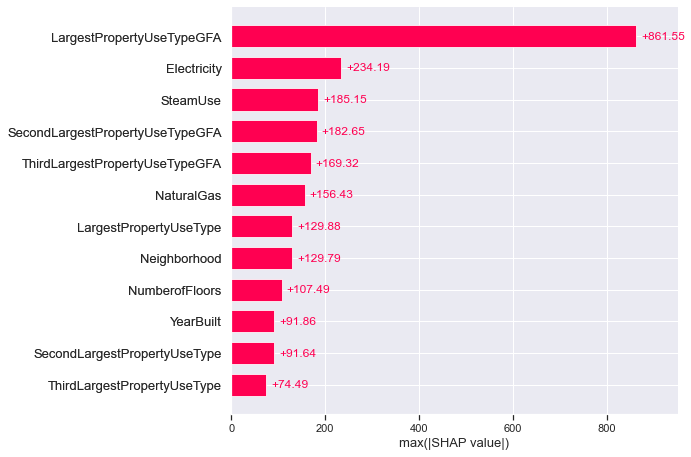

In [69]:
# Valeur maximale de la shap value en valeur absolue
shap.plots.bar(shap_values.abs.max(0), max_display=13)

## Influence locale

In [72]:
df_ = df.copy()
merge_property_types(df_)

In [73]:
shap_ind = np.random.randint(0, shap_vals.shape[0])
ind = X_test.iloc[[shap_ind]].index
print(shap_ind)
print(ind.values)
df_.loc[int(ind.values)]

166
[407]


Neighborhood                       NORTHEAST
YearBuilt                               2006
NumberofFloors                             3
LargestPropertyUseType                Office
LargestPropertyUseTypeGFA            83715.0
SecondLargestPropertyUseType         Parking
SecondLargestPropertyUseTypeGFA      18575.0
ThirdLargestPropertyUseType             None
ThirdLargestPropertyUseTypeGFA           0.0
ENERGYSTARScore                         26.0
TotalGHGEmissions                      49.17
GHGEmissionsIntensity                   0.48
SteamUse                                 0.0
Electricity                         0.975326
NaturalGas                          0.024674
Name: 407, dtype: object

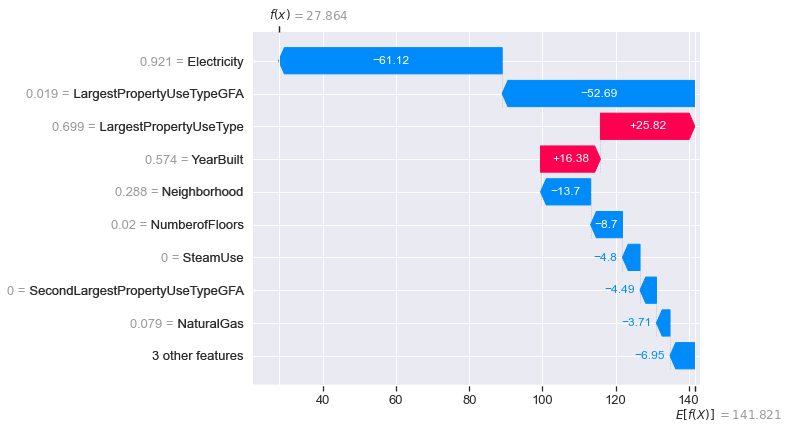

In [74]:
shap.plots.waterfall(shap_values[25])

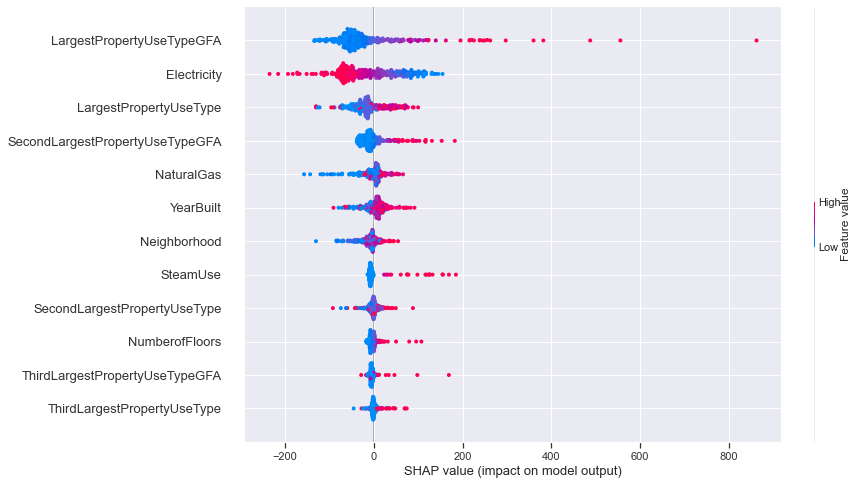

In [75]:
shap.plots.beeswarm(shap_values, plot_size=(12,8), log_scale=False, max_display=13)